In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pickle
import pkg_resources
import matplotlib.pyplot as plt
import numpy as np
import pprint
from pathlib import Path
from tqdm import trange

import flygym.util.vision as vision
from flygym.arena.mujoco_arena import FlatTerrain, GappedTerrain
from flygym.envs.nmf_mujoco import NeuroMechFlyMuJoCo, MuJoCoParameters
from flygym.util.config import all_leg_dofs

from arena import ObstacleOdorArena

pygame 2.5.1 (SDL 2.28.2, Python 3.11.0)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [3]:
run_time = 1
timestep = 1e-4
actuated_joints = all_leg_dofs

# Load recorded data
data_path = Path(pkg_resources.resource_filename("flygym", "data"))
with open(data_path / "behavior" / "210902_pr_fly1.pkl", "rb") as f:
    data = pickle.load(f)

# Interpolate 5x
num_steps = int(run_time / timestep)
data_block = np.zeros((len(actuated_joints), num_steps))
measure_t = np.arange(len(data["joint_LFCoxa"])) * data["meta"]["timestep"]
interp_t = np.arange(num_steps) * timestep
for i, joint in enumerate(actuated_joints):
    data_block[i, :] = np.interp(interp_t, measure_t, data[joint])

In [4]:
def sample_visual_data(
    nmf, obstacle_positions, action, visualize=False, camera="birdeye_cam_origin"
):
    # Change obstacle positions in the arena
    for i in range(obstacle_positions.shape[0]):
        pos_xyz = np.array([*obstacle_positions[i, :], nmf.arena.obstacle_z_pos])
        nmf.physics.bind(nmf.arena.obstacle_bodies[i]).mocap_pos = pos_xyz
    nmf.step(action)

    # Render visual input
    nmf._last_vision_update_time = -np.inf  # hack: this forces visual input update
    nmf._update_vision()
    visual_input = nmf.curr_visual_input.copy()
    raw_cam_imgs = nmf.curr_raw_visual_input.copy()

    # Calculate obstacle positions relative to the fly
    fly_rotation = nmf.get_observation()["fly"][2, 0] - np.pi / 2
    rot_matrix = np.array(
        [
            [np.cos(fly_rotation), -np.sin(fly_rotation)],
            [np.sin(fly_rotation), np.cos(fly_rotation)],
        ]
    )
    obstacle_positions_transformed = obstacle_positions - nmf.spawn_pos[:2]
    obstacle_positions_transformed[:, 1] *= -1  # change y to right-hand-positive
    obstacle_positions_transformed = (rot_matrix @ obstacle_positions_transformed.T).T

    # Visualize
    if visualize:
        fig, axs = plt.subplots(1, 5, figsize=(10, 5), tight_layout=True)
        birdeye_img = nmf.physics.render(camera_id=camera, height=512, width=512)
        axs[0].imshow(birdeye_img)
        axs[0].axis("off")
        for i in range(2):
            axs[i + 1].imshow(raw_cam_imgs[i], cmap="gray", vmin=0, vmax=255)
            axs[i + 1].axis("off")
        for i in range(2):
            vis = vision.hex_pxls_to_human_readable(
                visual_input[i], vision.ommatidia_id_map
            )
            axs[i + 3].imshow(vis, cmap="gray", vmin=0, vmax=255)
            axs[i + 3].axis("off")

    return visual_input, obstacle_positions_transformed

  0%|          | 0/2 [00:00<?, ?it/s]/home/sibwang/anaconda3/envs/flygym/lib/python3.11/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


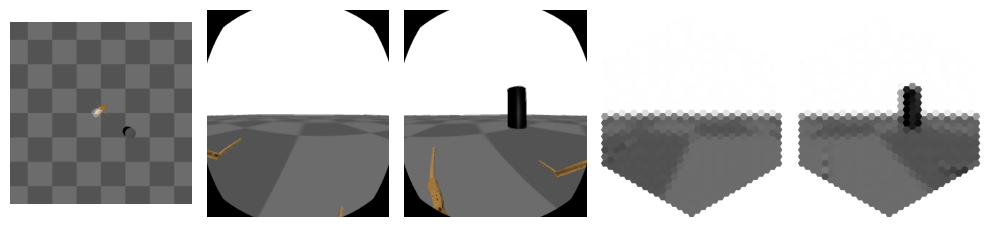

{'fly_heading': 2.1823361036426685,
 'fly_pos': array([0.20962883, 0.88320923]),
 'fly_state_idx': 0,
 'obstacle_dir': -0.7264511579796973,
 'obstacle_dist': 6.988509574287779,
 'obstacle_pos': array([ 5.43379356, -3.75870513]),
 'obstacle_position_rel': array([1.63715155, 6.78980604]),
 'obstacle_state_idx': 0,
 'terrain': 'flat',
 'visual_input': array([[[252.80172414,   0.        ],
        [  0.        , 255.        ],
        [255.        ,   0.        ],
        ...,
        [108.        ,   0.        ],
        [  0.        , 108.        ],
        [108.        ,   0.        ]],

       [[252.80172414,   0.        ],
        [  0.        , 255.        ],
        [255.        ,   0.        ],
        ...,
        [ 83.        ,   0.        ],
        [  0.        ,  83.        ],
        [ 94.44396552,   0.        ]]])}


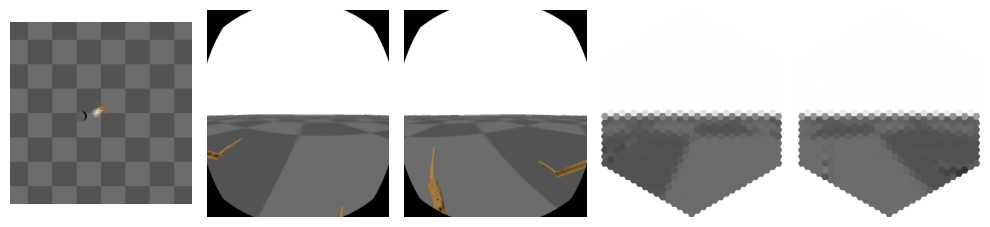

 50%|█████     | 1/2 [00:04<00:04,  4.84s/it]

{'fly_heading': 2.1823087520396034,
 'fly_pos': array([0.20906671, 0.88357974]),
 'fly_state_idx': 0,
 'obstacle_dir': -2.785254507782425,
 'obstacle_dist': 4.380276852355778,
 'obstacle_pos': array([-3.89604344, -0.64445689]),
 'obstacle_position_rel': array([-4.21402067, -1.11642957]),
 'obstacle_state_idx': 1,
 'terrain': 'flat',
 'visual_input': array([[[252.80172414,   0.        ],
        [  0.        , 255.        ],
        [255.        ,   0.        ],
        ...,
        [108.        ,   0.        ],
        [  0.        , 108.        ],
        [108.        ,   0.        ]],

       [[252.80172414,   0.        ],
        [  0.        , 255.        ],
        [255.        ,   0.        ],
        ...,
        [ 83.        ,   0.        ],
        [  0.        ,  83.        ],
        [ 94.28017241,   0.        ]]])}


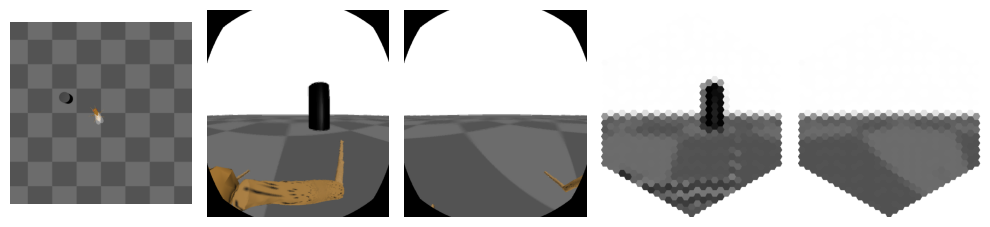

{'fly_heading': -2.7432011151227815,
 'fly_pos': array([-0.89532162, -0.05832921]),
 'fly_state_idx': 1,
 'obstacle_dir': 2.6741025445054722,
 'obstacle_dist': 6.5443564887514585,
 'obstacle_pos': array([-6.73748288,  2.89086621]),
 'obstacle_position_rel': array([ 5.01333809, -4.20890853]),
 'obstacle_state_idx': 0,
 'terrain': 'flat',
 'visual_input': array([[[252.80172414,   0.        ],
        [  0.        , 255.        ],
        [255.        ,   0.        ],
        ...,
        [ 83.        ,   0.        ],
        [  0.        ,  83.        ],
        [ 83.        ,   0.        ]],

       [[252.80172414,   0.        ],
        [  0.        , 255.        ],
        [255.        ,   0.        ],
        ...,
        [ 83.        ,   0.        ],
        [  0.        ,  83.        ],
        [ 83.        ,   0.        ]]])}


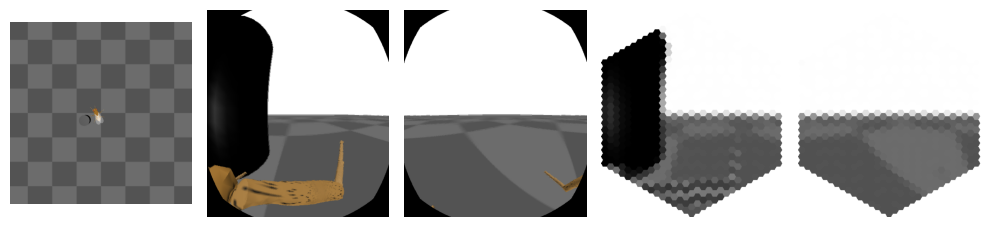

100%|██████████| 2/2 [00:07<00:00,  3.58s/it]


{'fly_heading': -2.741874330575819,
 'fly_pos': array([-0.89500076, -0.05821875]),
 'fly_state_idx': 1,
 'obstacle_dir': -2.594143117880226,
 'obstacle_dist': 2.5682884655830955,
 'obstacle_pos': array([-3.08794631, -1.39504165]),
 'obstacle_position_rel': array([-0.35169581, -2.5154208 ]),
 'obstacle_state_idx': 1,
 'terrain': 'flat',
 'visual_input': array([[[7.32758621e-02, 0.00000000e+00],
        [0.00000000e+00, 7.88381743e-01],
        [2.73706897e+00, 0.00000000e+00],
        ...,
        [8.30000000e+01, 0.00000000e+00],
        [0.00000000e+00, 8.30000000e+01],
        [8.30000000e+01, 0.00000000e+00]],

       [[2.52801724e+02, 0.00000000e+00],
        [0.00000000e+00, 2.55000000e+02],
        [2.55000000e+02, 0.00000000e+00],
        ...,
        [8.30000000e+01, 0.00000000e+00],
        [0.00000000e+00, 8.30000000e+01],
        [8.30000000e+01, 0.00000000e+00]]])}


  0%|          | 0/2 [00:00<?, ?it/s]

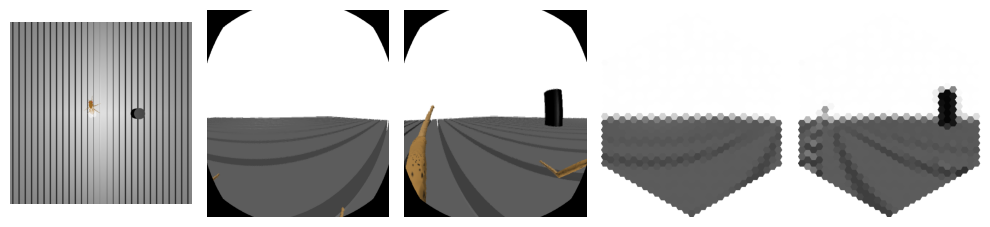

{'fly_heading': -3.0101503027712893,
 'fly_pos': array([-1.92022514,  1.36001337]),
 'fly_state_idx': 0,
 'obstacle_dir': -0.16582554216397138,
 'obstacle_dist': 8.96069806686749,
 'obstacle_pos': array([ 6.91755386, -0.11909863]),
 'obstacle_position_rel': array([-2.58652686,  8.57310174]),
 'obstacle_state_idx': 0,
 'terrain': 'gapped',
 'visual_input': array([[[252.80172414,   0.        ],
        [  0.        , 255.        ],
        [255.        ,   0.        ],
        ...,
        [ 91.48275862,   0.        ],
        [  0.        ,  92.        ],
        [ 92.        ,   0.        ]],

       [[252.80172414,   0.        ],
        [  0.        , 255.        ],
        [255.        ,   0.        ],
        ...,
        [ 81.57327586,   0.        ],
        [  0.        ,  91.85950413],
        [ 92.22413793,   0.        ]]])}


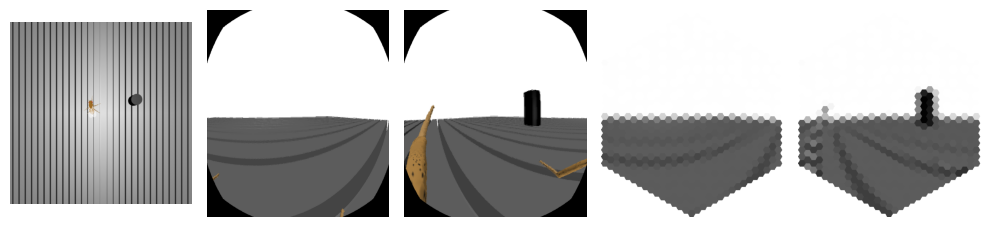

 50%|█████     | 1/2 [00:02<00:02,  2.54s/it]

{'fly_heading': -3.0111675064853927,
 'fly_pos': array([-1.92057589,  1.36023747]),
 'fly_state_idx': 0,
 'obstacle_dir': 0.12866379864420052,
 'obstacle_dist': 8.407286015837155,
 'obstacle_pos': array([6.4172174 , 2.43896878]),
 'obstacle_position_rel': array([0.0233882 , 8.40968667]),
 'obstacle_state_idx': 1,
 'terrain': 'gapped',
 'visual_input': array([[[252.80172414,   0.        ],
        [  0.        , 255.        ],
        [255.        ,   0.        ],
        ...,
        [ 91.56034483,   0.        ],
        [  0.        ,  92.        ],
        [ 92.        ,   0.        ]],

       [[252.80172414,   0.        ],
        [  0.        , 255.        ],
        [255.        ,   0.        ],
        ...,
        [ 81.43965517,   0.        ],
        [  0.        ,  91.78512397],
        [ 92.21982759,   0.        ]]])}


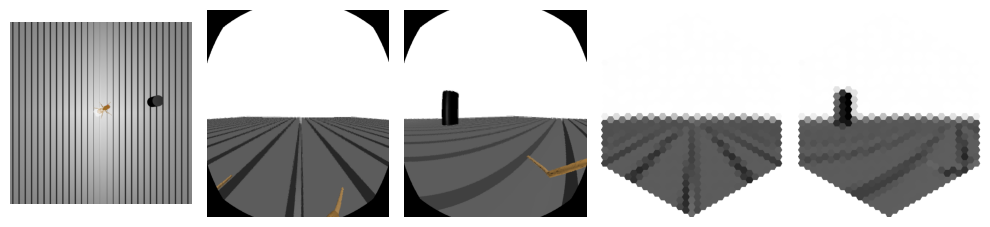

{'fly_heading': 2.067102608249227,
 'fly_pos': array([0.75799808, 0.87846388]),
 'fly_state_idx': 1,
 'obstacle_dir': 0.13727705420658243,
 'obstacle_dist': 9.557351336396671,
 'obstacle_pos': array([10.22543665,  2.18635201]),
 'obstacle_position_rel': array([8.98056798, 3.3893804 ]),
 'obstacle_state_idx': 0,
 'terrain': 'gapped',
 'visual_input': array([[[252.80172414,   0.        ],
        [  0.        , 255.        ],
        [255.        ,   0.        ],
        ...,
        [ 91.17672414,   0.        ],
        [  0.        ,  87.07024793],
        [ 56.36206897,   0.        ]],

       [[252.80172414,   0.        ],
        [  0.        , 255.        ],
        [255.        ,   0.        ],
        ...,
        [ 92.        ,   0.        ],
        [  0.        ,  90.45454545],
        [103.27155172,   0.        ]]])}


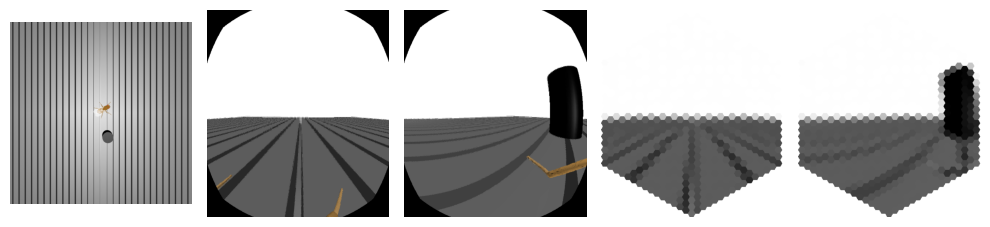

100%|██████████| 2/2 [00:05<00:00,  2.54s/it]

{'fly_heading': 2.0679323165809875,
 'fly_pos': array([0.7588008 , 0.87867671]),
 'fly_state_idx': 1,
 'obstacle_dir': -1.479340718682099,
 'obstacle_dist': 5.317295519924189,
 'obstacle_pos': array([ 1.24441967, -4.41639703]),
 'obstacle_position_rel': array([-2.0666467 ,  4.90788575]),
 'obstacle_state_idx': 1,
 'terrain': 'gapped',
 'visual_input': array([[[252.80172414,   0.        ],
        [  0.        , 255.        ],
        [255.        ,   0.        ],
        ...,
        [ 91.58189655,   0.        ],
        [  0.        ,  85.5       ],
        [ 57.59051724,   0.        ]],

       [[252.80172414,   0.        ],
        [  0.        , 255.        ],
        [255.        ,   0.        ],
        ...,
        [ 92.        ,   0.        ],
        [  0.        ,  90.25619835],
        [103.16810345,   0.        ]]])}


In [5]:
fly_pos_range = [-2, 2]
fly_heading_range = [-np.pi, np.pi]
obs_dist_range = [2, 10]
obs_dir_range = [-np.pi, np.pi]
fly_pos_idx_range = [0, data_block.shape[1] - 1]
num_fly_state_samples = 2
num_obstacle_state_samples_per_fly_state = 2
debug = True

res_all = []

np.random.seed(0)

for terrain in ["flat", "gapped"]:
    for i in trange(num_fly_state_samples):
        if terrain == "flat":
            terrain_arena = FlatTerrain()
        elif terrain == "gapped":
            terrain_arena = GappedTerrain(
                x_range=(-20, 20), y_range=(-20, 20), gap_width=0.25, ground_alpha=1
            )
        else:
            raise ValueError(f"Unknown terrain: {terrain}")
        arena = ObstacleOdorArena(
            terrain=terrain_arena,
            obstacle_positions=np.array([[10, 0]]),
            marker_size=0.5,
            obstacle_colors=(0, 0, 0, 1),
            user_camera_settings=((16, -30, 11), (np.deg2rad(75), 0, 0), 30),
        )
        sim_params = MuJoCoParameters(
            render_playspeed=0.2,
            render_camera="user_cam",
            enable_vision=True,
            render_raw_vision=True,
            enable_olfaction=True,
        )
        nmf = NeuroMechFlyMuJoCo(
            sim_params=sim_params,
            arena=arena,
            spawn_pos=(*np.random.uniform(*fly_pos_range, size=(2,)), 0.2),
            spawn_orient=(0, 0, np.pi / 2 + np.random.uniform(*fly_heading_range)),
        )
        action = {"joints": data_block[:, np.random.randint(*fly_pos_idx_range)]}
        for _ in range(50):
            nmf.step(action)

        num_obs_states_sampled = 0
        while num_obs_states_sampled < num_obstacle_state_samples_per_fly_state:
            fly_pos = nmf.get_observation()["fly"][0, :2]
            fly_heading = nmf.get_observation()["fly"][2, 0]
            obs_dist = np.random.uniform(*obs_dist_range)
            obs_dir = np.random.uniform(*obs_dir_range)
            obs_dx = obs_dist * np.cos(obs_dir)
            obs_xy = obs_dist * np.sin(obs_dir)
            obstacle_position = np.array([obs_dx, obs_xy]) + fly_pos
            visual_input, obstacle_positions_transformed = sample_visual_data(
                nmf,
                obstacle_position.reshape(1, -1),
                action=action,
                visualize=debug,
            )
            entry = {
                "terrain": terrain,
                "fly_state_idx": i,
                "obstacle_state_idx": num_obs_states_sampled,
                "visual_input": visual_input,
                "obstacle_position_rel": obstacle_positions_transformed[0],
                "fly_pos": fly_pos,
                "obstacle_pos": obstacle_position,
                "fly_heading": fly_heading,
                "obstacle_dist": obs_dist,
                "obstacle_dir": obs_dir,
            }
            res_all.append(entry)
            num_obs_states_sampled += 1
            if debug:
                plt.show()
                pprint.pprint(entry)

In [6]:
fly_pos_range = [-2, 2]
fly_heading_range = [-np.pi, np.pi]
obs_dist_range = [0, 10]
obs_dir_range = [-np.pi, np.pi]
fly_pos_idx_range = [0, data_block.shape[1] - 1]
num_fly_state_samples = 1000
num_obstacle_state_samples_per_fly_state = 10
debug = False

res_all = []

np.random.seed(0)

for terrain in ["flat", "gapped"]:
    for i in trange(num_fly_state_samples):
        if terrain == "flat":
            terrain_arena = FlatTerrain()
        elif terrain == "gapped":
            terrain_arena = GappedTerrain(
                x_range=(-20, 20), y_range=(-20, 20), gap_width=0.25, ground_alpha=1
            )
        else:
            raise ValueError(f"Unknown terrain: {terrain}")
        arena = ObstacleOdorArena(
            terrain=terrain_arena,
            obstacle_positions=np.array([[10, 0]]),
            marker_size=0.5,
            obstacle_colors=(0, 0, 0, 1),
            user_camera_settings=((16, -30, 11), (np.deg2rad(75), 0, 0), 30),
        )
        sim_params = MuJoCoParameters(
            render_playspeed=0.2,
            render_camera="user_cam",
            enable_vision=True,
            render_raw_vision=True,
            enable_olfaction=True,
        )
        nmf = NeuroMechFlyMuJoCo(
            sim_params=sim_params,
            arena=arena,
            spawn_pos=(*np.random.uniform(*fly_pos_range, size=(2,)), 0.2),
            spawn_orient=(0, 0, np.pi / 2 + np.random.uniform(*fly_heading_range)),
        )
        action = {"joints": data_block[:, np.random.randint(*fly_pos_idx_range)]}
        for _ in range(50):
            nmf.step(action)

        num_obs_states_sampled = 0
        while num_obs_states_sampled < num_obstacle_state_samples_per_fly_state:
            fly_pos = nmf.get_observation()["fly"][0, :2]
            fly_heading = nmf.get_observation()["fly"][2, 0]
            obs_dist = np.random.uniform(*obs_dist_range)
            obs_dir = np.random.uniform(*obs_dir_range)
            obs_dx = obs_dist * np.cos(obs_dir)
            obs_xy = obs_dist * np.sin(obs_dir)
            obstacle_position = np.array([obs_dx, obs_xy]) + fly_pos
            visual_input, obstacle_positions_transformed = sample_visual_data(
                nmf,
                obstacle_position.reshape(1, -1),
                action=action,
                visualize=debug,
            )
            entry = {
                "terrain": terrain,
                "fly_state_idx": i,
                "obstacle_state_idx": num_obs_states_sampled,
                "visual_input": visual_input,
                "obstacle_position_rel": obstacle_positions_transformed[0],
                "fly_pos": fly_pos,
                "obstacle_pos": obstacle_position,
                "fly_heading": fly_heading,
                "obstacle_dist": obs_dist,
                "obstacle_dir": obs_dir,
            }
            res_all.append(entry)
            num_obs_states_sampled += 1
            if debug:
                plt.show()
                pprint.pprint(entry)

100%|██████████| 1000/1000 [42:19<00:00,  2.54s/it]


In [7]:
with open("data/vision/visual_training_data.pkl", "wb") as f:
    pickle.dump(res_all, f)